In [ ]:
# -- 1. separate the coastal data into continents
# -- AFRICA
# -- ASIA,...
# -- Save data in json files per continent

# -- Two methods of plotting:
# --    - loop on all the grid points (if better)
# --    - plot by color

In [2]:
import Ngl, Nio
import os, numpy, csv
from IPython.display import Image
from shapely.geometry import Polygon, Point
import geopandas


# -- Create empty map over region
# --    test with and without gray fill over continent
#----------------------------------------------------------------------
# Create map of southern tip of South America
#----------------------------------------------------------------------
def create_map(wks, region_dict):
    #---Map resources
    res            = Ngl.Resources()   # map resources
    res.nglDraw    = False         # don't draw map
    res.nglFrame   = False         # don't advance frame

    res.mpDataBaseVersion = "MediumRes"   # better map outlines

    res.mpLimitMode = "LatLon"
    res.mpProjection = "Robinson"
    res.mpMaxLatF   = region_dict['latmax']           # select subregion
    res.mpMinLatF   = region_dict['latmin']
    res.mpMinLonF   = region_dict['lonmin']
    res.mpMaxLonF   = region_dict['lonmax']

    res.mpOutlineOn     = True
    res.mpGridAndLimbOn = True
    res.mpGridLineColor = -1
    res.mpFillOn               = True
    res.mpLandFillColor        = "grey"
    res.mpOceanFillColor       = "white"
    res.mpInlandWaterFillColor = "white"
    # Remove box around plot
    res.pmTickMarkDisplayMode = "Never"

    # Remove Lon/lat ticks
    res.tmXBOn = False
    res.tmYLOn = False
    res.tmXTOn = False
    res.tmYROn = False


    #res.tiMainString = title
    #res.tiMainFontHeightF = 0.02

    map = Ngl.map(wks,res)    # Draw map.

    return map


# -- Add points
# --   - read the csv
# --   - use add_trajectories to add the points
# --   - only for the region!
# --   - Store only the points for the region

#----------------------------------------------------------------------
#  Add the trajectory lines.
#----------------------------------------------------------------------
def color_index(val, inc):
    
    ninc = len(inc) #len(inc)-1 : n ticks => n-1 colors ; + 2 => left and right colors

    if val in inc:
        ind = list(inc).index(val)
    elif val<numpy.array(inc).min():
        ind = -1
    elif val>numpy.array(inc).max():
        ind = len(inc)-1
    else:
        tmp = val - numpy.array(inc)
        if val<0:
            tmp = tmp * -1
        dum = tmp[tmp<0]
        if val<0:
            ind = list(tmp).index(dum[dum.argmax()])
        else:
            ind = list(tmp).index(dum[dum.argmax()]) - 1
    return ind+1


# -- Je lis les AR6 regions et garde uniquement celles de la region_name
# --   - pour la selection des points: subregions_polygons
# --   - pour le plot des polygons : lons_array / lats_array
# -- add_trajectories:
# --   - je lis le fichier
# --   - je verifie si le point est dans une des subregions
# --   - si oui, je rajoute au plot

#
def retrieve_AR6regions_for_region(region_name):
    
    regions_filename='/home/jservon/Chapter12_IPCC/scripts/ATLAS/reference-regions/IPCC-WGI-reference-regions-v4_coordinates.csv'

    # -- Store the informations by region in the 'regions' dictionary
    regions = dict()
    with open(regions_filename) as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')#, quotechar='|')
        for row in spamreader:
            if row[0]==region_name:
                region_dict = dict()
                lats_vect = []
                lons_vect = []
                tmp_polygon_vertices = []
                for vertice in row[4:-1]:
                    if vertice:
                        dum = vertice.split('|')
                        lons_vect.append(float(dum[0]))
                        lats_vect.append(float(dum[1]))
                        tmp_polygon_vertices.append( (float(dum[0]), float(dum[1])) )
                region_dict['polygon'] = Polygon(tmp_polygon_vertices)
                region_dict['lons_vect'] = lons_vect
                region_dict['lats_vect'] = lats_vect
                #
                regions[row[3]] = region_dict
    #
    return regions


# -- Retrieve AR6 regions and select only AFRICA regions (+ bonus regions?)
# -- 
def add_CR_data_points(wks, map, scenario, horizon, regions, inc, colormap):

    # -- Start the plot
    mres  = Ngl.Resources()                    # marker resources
    mres.gsMarkerSizeF       = 7.0            # marker size
    mres.gsMarkerIndex       = 16              # circle with an X
    mres.gsMarkerThicknessF  = 1.0             # thicker marker outlines

    sid = []
    #
    if isinstance(colormap, str):
        colors = Ngl.read_colormap_file(colormap)
    else:
        colors = colormap
    ninc = len(inc) #len(inc)-1 : n ticks => n-1 colors ; + 2 => left and right colors
    indcolors = [0]
    for val in numpy.arange(0, len(colors)-1, float(len(colors)-1)/(ninc+1)).tolist()[1:-1]:
        indcolors.append(int(val))
    indcolors.append(len(colors)-1)
    cmap = colors[indcolors]

    # -- if lon/lat in subregions
    subregions_polygons = []
    for subregion in regions:
        subregions_polygons.append(regions[subregion]['polygon'])
    subregions = geopandas.GeoSeries( subregions_polygons )

    # -- Start a plot to check that the data is properly located in the regions
    # -----------------------------------------------------------------
    filename = '/home/ciles/IPCC/coastal/globalErosionProjections_Long_Term_Change_'+scenario+'_'+horizon+'.csv'
    
    print 'Reading coastal recession data for ',scenario,horizon
    with open(filename) as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        i = 0
        lons_list = []
        lats_list = []
        CR_list = []
        
        for row in spamreader:
            lon = float(row[1])
            lat = float(row[0])
            # -- Check whether lon/lat is within one of the subregions
            # -- If yes, add to the plot
            if subregions.contains( Point(lon,lat) ).any():
                coastal_recession_value = float(row[5])
                cindex = color_index(coastal_recession_value, inc)
                mres.gsMarkerColor = cmap[cindex]
                # -- Do the plot
                sid.append(Ngl.add_polymarker(wks,map,lon,lat,mres))
                Ngl.add_polymarker(wks,map,lon,lat,mres)
                lons_list.append(lon)
                lats_list.append(lat)
                CR_list.append(coastal_recession_value)
    
    return dict(lons_list=lons_list, lats_list=lats_list, CR_list=CR_list)


def add_AR6regions(wks, base_map, regions):
    #
    gsres                   = Ngl.Resources()
    # Polyline resources.
    gsres.gsLineColor       = "Black"
    gsres.gsLineThicknessF  = 3.0      # thrice thickness

    for subregion in regions:
        #if regions[subregion]['region']==region_name:
        lons_vect = regions[subregion]['lons_vect']
        lats_vect = regions[subregion]['lats_vect']
        # -- Close the polygon
        lons_vect.append(lons_vect[0])
        lats_vect.append(lats_vect[0])
        poly1 = Ngl.add_polyline(wks,base_map,lons_vect,lats_vect,gsres)
    #
    return


def add_labelbar(wks,map,inc,colormap):
    gsres = Ngl.Resources()  # Line resources.

    txres = Ngl.Resources()          # For labeling the label bar.
    txres.txFontHeightF = 0.015
    #txres.txJust        = "CenterLeft"       # Left justify
    gid = []
    lid = []
    tid = []
    
    if isinstance(colormap, str):
        colors = Ngl.read_colormap_file(colormap)
    else:
        colors = colormap
    ninc = len(inc) #len(inc)-1 : n ticks => n-1 colors ; + 2 => left and right colors
    indcolors = [0]
    for val in numpy.arange(0, len(colors)-1, float(len(colors)-1)/(ninc+1)).tolist()[1:-1]:
        indcolors.append(int(val))
    indcolors.append(len(colors)-1)
    cmap = colors[indcolors]
    
    yp = 0.2
    height = 0.03
    xp = 0.2
    xpend = 0.8
    width = (xpend - xp) / len(cmap)
    for i in range(0,len(cmap)):
        xbox = [xp,xp+width,xp+width,xp,xp]
        ybox = [yp,yp,yp-height,yp-height,yp]
        gsres.gsFillColor = cmap[i]    # Change fill color.
        if i==0:
            xbox = [xp,xp+width,xp+width,xp]
            ybox = [yp-height/2,yp,yp-height,yp-height/2]
        elif i==len(inc):
            xbox = [xp,xp+width,xp,xp]
            ybox = [yp,yp-height/2,yp-height,yp]
        gid.append(Ngl.polygon_ndc(wks,xbox,ybox,gsres))
        lid.append(Ngl.polyline_ndc(wks,xbox,ybox,gsres))            
        if i<len(inc):
            tid.append(Ngl.text_ndc(wks,str(inc[i]),xp+width, yp-height-0.02,txres))
        xp = xp + width

    return



#def plot_coastal_recession(wks, scenario, horizon, region_dict, inc, colormap, title):
#
# -- Do the plot
# -----------------------------------------------
colormap = "MPL_BrBG"
inc = [-500, -200, -100, -50, 0, 50, 100, 200, 500]

title = 'Coastal Recession'
scenario = 'RCP85'
horizon = '2100'
region_dict = dict(name='AFRICA',
                    lonmin = -30,
                    lonmax = 70,
                    latmin = -50,
                    latmax = 45
                   )


outfilename = 'Coastal_Recession_'+str(horizon)+'_'+scenario
wks = Ngl.open_wks("png",outfilename)
#plot_coastal_recession(wks, scenario, horizon, region_dict, inc, colormap, title)


map = create_map(wks, region_dict)

region_name = region_dict['name']

# -- Extract the subregions of the region
regions = retrieve_AR6regions_for_region(region_name)

# -- Add the data points
region_data = add_CR_data_points(wks,
                                   map,
                                   scenario,
                                   horizon,
                                   regions,
                                   inc,
                                   colormap)

# -- Add the AR6 regions
add_AR6regions(wks, map, regions)

# -- Color palette
add_labelbar(wks, map, inc, colormap)

Ngl.draw(map)

#pp['tiMainFontHeightF'] = 0.03
#pp['gsnStringFontHeightF'] = 0.025

# Set up some text resources.
txres                       = Ngl.Resources()  
txres.txFontHeightF         = 0.025

# Draw a text string labeling the marker
Ngl.text_ndc(wks,"Coastal recession",0.5,0.77,txres)
#Ngl.text_ndc(wks,label,0.05,0.77,txres)

tmainxres                       = Ngl.Resources()  
tmainxres.txFontHeightF         = 0.03
tmainxres.txFont         = 22
#tmainxres.txFontThicknessF  = 10
Ngl.text_ndc(wks,title,0.5,0.82,tmainxres)

Ngl.frame(wks)

#Ngl.overlay(contour, contour2)
#Ngl.draw(contour)
#Ngl.draw(contour2)
#Ngl.frame(wks)

Ngl.end()

del(wks)
del(map)
#


if None:
    # -- Do the plot
    # -----------------------------------------------
    colormap = "MPL_BrBG"
    inc = [-500, -200, -100, -50, 0, 50, 100, 200, 500]

    title = 'Coastal Recession'
    scenario = 'RCP85'
    horizon = '2100'
    region_dict = dict(name='AFRICA',
                        lonmin = -30,
                        lonmax = 70,
                        latmin = -50,
                        latmax = 45
                       )


    outfilename = 'Coastal_Recession_'+str(horizon)+'_'+scenario
    wks = Ngl.open_wks("png",outfilename)
    plot_coastal_recession(wks, scenario, horizon, region_dict, inc, colormap, title)
    #plot_esl_change(wks, baseline, future, horizon, inc, colormap, title)

Reading coastal recession data for  RCP85 2100


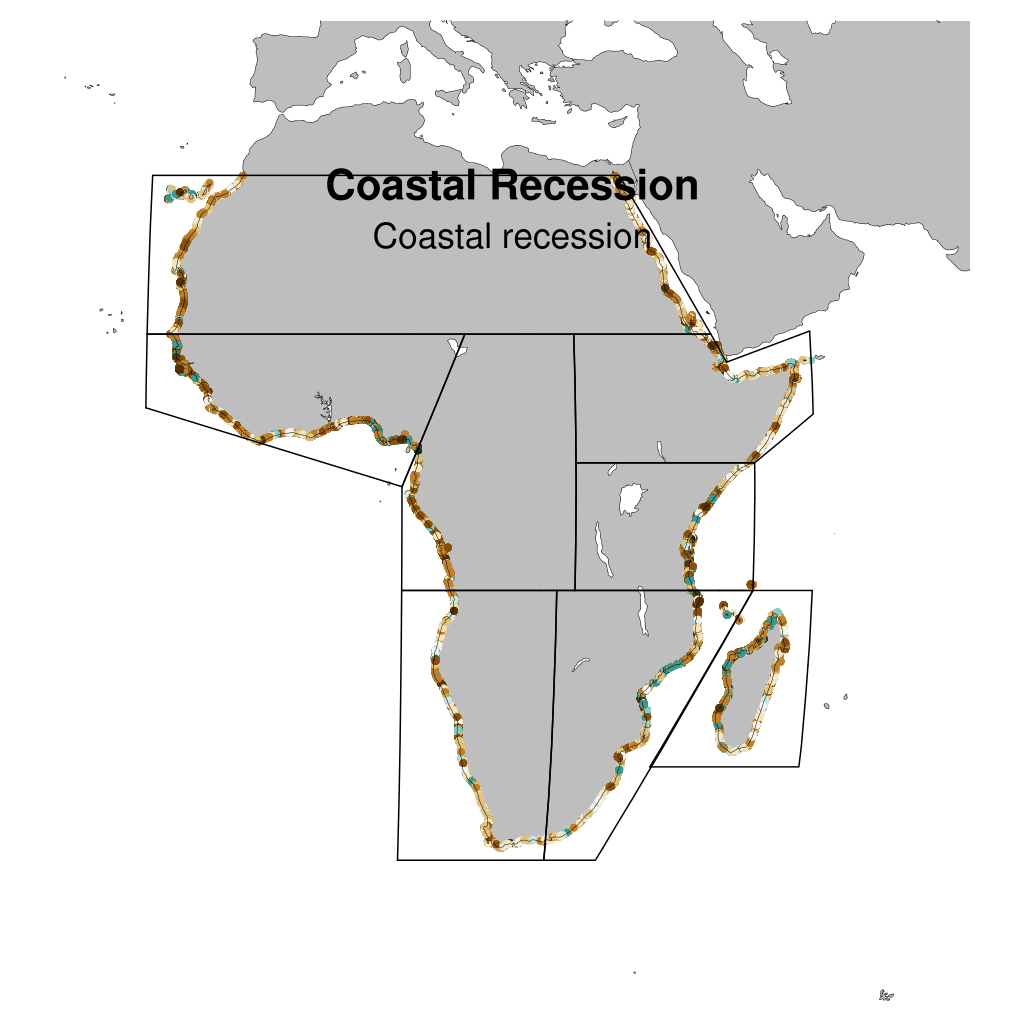

In [6]:
Image(outfilename+'.png')
#outfilename

In [4]:
!ls -ltr

total 38796
-rw-r--r-- 1 jservon ciclad     2676 21 déc.  09:31 Browse_CMIP6_data.ipynb
-rw-r--r-- 1 jservon ciclad     1021  4 janv. 15:53 multipanelfigure_test.R
-rw-r--r-- 1 jservon ciclad  4031699  5 janv. 09:43 Figure_1_multipanel.ipynb
-rw-r--r-- 1 jservon ciclad   202499  7 janv. 14:17 pyNGL_firsttest.ipynb
-rw-r--r-- 1 jservon ciclad      219  7 janv. 18:07 climaf.log
-rw-r--r-- 1 jservon ciclad      878  7 janv. 18:08 last.out
-rw-r--r-- 1 jservon ciclad   371834  8 janv. 00:20 plot_ipcc_climaf.ipynb
-rw-r--r-- 1 jservon ciclad    84485  9 janv. 13:30 satellite2.png
-rw-r--r-- 1 jservon ciclad    80831  9 janv. 14:43 Rplot001.png
-rw-r--r-- 1 jservon ciclad    39759  9 janv. 15:20 satellite_coastal.png
-rw-r--r-- 1 jservon ciclad   127721 11 janv. 21:48 satellite.png
-rw-r--r-- 1 jservon ciclad   432158 11 janv. 22:34 Quantile_plot_region.ipynb
-rw-r--r-- 1 jservon ciclad    91381 13 janv. 18:40 Reference_Regions_R.ipynb
-rw-r--r-- 1 jservon ciclad    12614 14 janv. 23:25 Aver

In [7]:
# -- Trim the figure and extract the colorbar
# -----------------------------------------------
from PIL import Image as PILImage

def extract_labelbar(figure_file,labelbar_file) :
    im = PILImage.open(figure_file)
    #box=(left, upper, right, lower).
    im_crop = im.crop((190, 810, 820, 885))
    im_crop.save(labelbar_file, quality=95)

def extract_plot(figure_file,trim_figure) :
    im = PILImage.open(figure_file)
    #box=(left, upper, right, lower).
    im_crop = im.crop((20, 165, 1010, 763))
    im_crop.save(trim_figure, quality=95)


# -- color bar file
variable = 'CoastalRecession'
colorbar_file = '/home/jservon/Chapter12_IPCC/figs/AFRICA_regional_figure/'+variable+'_colorbar.png'
# -- Extract the colorbar
extract_labelbar(outfilename,colorbar_file)
extract_plot(outfilename,trim_figure)

Reading coastal recession data for  RCP85 2100


NameError: global name 'label' is not defined

In [ ]:
# -- Do the plot
# -----------------------------------------------
colormap = "MPL_BrBG"
inc = [-500, -200, -100, -50, 0, 50, 100, 200, 500]

title = 'Coastal Recession'
scenario = 'RCP85'
horizon = '2100'
region_dict = dict(name='AFRICA',
                    lonmin = -30,
                    lonmax = 70,
                    latmin = -50,
                    latmax = 45
                   )


outfilename = 'Coastal_Recession_'+str(horizon)+'_'+scenario
wks = Ngl.open_wks("png",outfilename)
#plot_coastal_recession(wks, scenario, horizon, region_dict, inc, colormap, title)

#

region_name = region_dict['name']

# -- Extract the subregions of the region
regions = retrieve_AR6regions_for_region(region_name)


map = create_map(wks, region_dict)

# -- Add the data points
add_CR_data_points(wks,
                   map,
                   scenario,
                   horizon,
                   regions,
                   inc,
                   colormap)

# -- Add the AR6 regions
add_AR6regions(wks, map, regions)

# -- Color palette
add_labelbar(wks, map, inc, colormap)

Ngl.draw(map)

#pp['tiMainFontHeightF'] = 0.03
#pp['gsnStringFontHeightF'] = 0.025

# Set up some text resources.
txres                       = Ngl.Resources()  
txres.txFontHeightF         = 0.025

# Draw a text string labeling the marker
Ngl.text_ndc(wks,"Coastal recession",0.5,0.77,txres)
#Ngl.text_ndc(wks,label,0.05,0.77,txres)

tmainxres                       = Ngl.Resources()  
tmainxres.txFontHeightF         = 0.03
tmainxres.txFont         = 22
#tmainxres.txFontThicknessF  = 10
Ngl.text_ndc(wks,title,0.5,0.82,tmainxres)

Ngl.frame(wks)

#Ngl.overlay(contour, contour2)
#Ngl.draw(contour)
#Ngl.draw(contour2)
#Ngl.frame(wks)

Ngl.end()

del(wks)
del(map)
#


#plot_esl_change(wks, baseline, future, horizon, inc, colormap, title)


# -- Trim the figure and extract the colorbar
# -----------------------------------------------
from PIL import Image as PILImage

def extract_labelbar(figure_file,labelbar_file) :
    im = PILImage.open(figure_file)
    #box=(left, upper, right, lower).
    im_crop = im.crop((190, 810, 820, 885))
    im_crop.save(labelbar_file, quality=95)

def extract_plot(figure_file,trim_figure) :
    im = PILImage.open(figure_file)
    #box=(left, upper, right, lower).
    im_crop = im.crop((20, 165, 1010, 763))
    im_crop.save(trim_figure, quality=95)


# -- color bar file
variable = 'CoastalRecession'
colorbar_file = '/home/jservon/Chapter12_IPCC/figs/AFRICA_regional_figure/'+variable+'_colorbar.png'
# -- Extract the colorbar
extract_labelbar(outfilename,colorbar_file)
extract_plot(outfilename,trim_figure)


In [ ]:
Image(trim_figure)

In [ ]:
Image(colorbar_file)

In [3]:
!ls -ltr

total 38772
-rw-r--r-- 1 jservon ciclad     2676 21 déc.  09:31 Browse_CMIP6_data.ipynb
-rw-r--r-- 1 jservon ciclad     1021  4 janv. 15:53 multipanelfigure_test.R
-rw-r--r-- 1 jservon ciclad  4031699  5 janv. 09:43 Figure_1_multipanel.ipynb
-rw-r--r-- 1 jservon ciclad   202499  7 janv. 14:17 pyNGL_firsttest.ipynb
-rw-r--r-- 1 jservon ciclad      219  7 janv. 18:07 climaf.log
-rw-r--r-- 1 jservon ciclad      878  7 janv. 18:08 last.out
-rw-r--r-- 1 jservon ciclad   371834  8 janv. 00:20 plot_ipcc_climaf.ipynb
-rw-r--r-- 1 jservon ciclad    84485  9 janv. 13:30 satellite2.png
-rw-r--r-- 1 jservon ciclad    80831  9 janv. 14:43 Rplot001.png
-rw-r--r-- 1 jservon ciclad    39759  9 janv. 15:20 satellite_coastal.png
-rw-r--r-- 1 jservon ciclad   127721 11 janv. 21:48 satellite.png
-rw-r--r-- 1 jservon ciclad   432158 11 janv. 22:34 Quantile_plot_region.ipynb
-rw-r--r-- 1 jservon ciclad    91381 13 janv. 18:40 Reference_Regions_R.ipynb
-rw-r--r-- 1 jservon ciclad    12614 14 janv. 23:25 Aver

In [ ]:
from shapely.geometry import Polygon, Point
import geopandas

subregions_polygons = []
polygon1_vertices = [ (0,0), (0,1), (1,1), (1,0)]
polygon2_vertices = [ (1.1,0), (1.1,1), (2,1), (2,1.1)]
subregions_polygons = [Polygon(polygon1_vertices), Polygon(polygon2_vertices)]
#.append( Polygon(tmp_polygon_vertices) )
    
# -- if lon/lat in subregions
subregions = geopandas.GeoSeries( subregions_polygons )

In [22]:
point = Point(1.05, 0.5)
points_list = [point]

#points_in_AR6_regions = geopandas.GeoSeries( point )
#are_points_in_subregions = subregions.apply(lambda x: points_in_AR6_regions.within(x)).as_matrix()
#are_points_in_subregions = subregions.apply(lambda x: points_in_AR6_regions.within(x)).as_matrix()
#are_points_in_subregions.any()
subregions.contains(point).any()

False

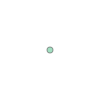

In [21]:
point

In [14]:
dir(subregions)

['T',
 '_AXIS_ALIASES',
 '_AXIS_IALIASES',
 '_AXIS_LEN',
 '_AXIS_NAMES',
 '_AXIS_NUMBERS',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '_AXIS_SLICEMAP',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_prepare__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__bytes__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__geo_interface__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__idiv__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__long__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',

In [ ]:
    CR_list =
    for 
    with open(filename) as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        i = 0
        lons_list = []
        lats_list = []
        CR_list = []
        
        for row in spamreader:
            lon = float(row[1])
            lat = float(row[0])
            # -- Check whether lon/lat is within one of the subregions
            # -- If yes, add to the plot
            if subregions.contains( Point(lon,lat) ).any():
                coastal_recession_value = float(row[5])
                cindex = color_index(coastal_recession_value, inc)
                mres.gsMarkerColor = cmap[cindex]
                # -- Do the plot
                sid.append(Ngl.add_polymarker(wks,map,lon,lat,mres))
                Ngl.add_polymarker(wks,map,lon,lat,mres)
                lons_list.append(lon)
                lats_list.append(lat)
                CR_list.append(coastal_recession_value)


In [ ]:



inc = [-500, -200, -100, -50, 0, 50, 100, 200, 500]
cindex = data*0
for i in range(0,len(inc)):
    # -- Get the cindex of all points
    if i==0:
        tmp_cindex = np.where(data<inc[i])
    elif i==(len(inc)-1):
        tmp_cindex = np.where(data>=inc[i])
    else:
        tmp_cindex = np.where(data>=inc[i] and data<inc[i+1])
    cindex[tmp_cindex] = i